In [1]:
import librosa
import librosa.display
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import tqdm

In [22]:
FILE_PATH = 'audio_samples/1.wav'
SAMPLE_NAME = 'Piano'

#~~~~~~~~~~~~~~ PARAMETERS ~~~~~~~~~~~~~~
SAMPLE_RATE = 16000
OFFSET = 0
DURATION = 50
HOP_LENGTH = 512
KERNEL_SIZE = 40
VISUALIZATION = True
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [3]:
def chord_dictionary():
    """
    This function prepares the chord dictionary consist of C major and C minor chords.
    The chords tempelate are used to generate each of the corresponding chords, where
    "1" represents the full presence of the pitch and "0" represents the total absence.
    
    Returns:
    The chord dictionary.
    """
    dictionary = {}

    majors = ["C","Db","D","Eb","E","F","F#","G","Ab","A","Bb","B"]
    minors = ["Cm","Dbm","Dm","Ebm","Em","Fm","F#m","Gm","Abm","Am","Bbm","Bm"]

    # Chords template
    tc  = [1, 0, 0.3, 0, 1, 0, 0, 1, 0, 0, 0.3, 0.1] # C major
    tcm = [1, 0, 0.3, 1, 0, 0, 0, 1, 0, 0, 0.3, 0] # C minor
    shifted = 0

    for chord in majors:
        dictionary[chord] = tc[12 - shifted:] + tc[:12 - shifted]
        shifted += 1

    for chord in minors:
        dictionary[chord] = tcm[12 - shifted:] + tcm[:12 - shifted]
        shifted += 1

    # In case of no chord
    tnc = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    dictionary["NC"] = tnc

    return dictionary

In [4]:
def cosine_similarity (feature, chord):
    """
    This function represents the similarity between a feature obtained from audio file
    and a chord from the dictionary by computing the cosine similarity.

    Parameters:
    feature (non-negative vector) : The chroma feature vector
    chord (non-negative vector) The chord representation

    Returns:
    The cosine similarity of the feature and the pitch.
    """
    return np.dot(feature, chord) / (np.linalg.norm(feature) * np.linalg.norm(chord))

In [20]:
def chroma_features(file, sample_rate, offset, duration, hop_length, display=False):
    """
    This function takes the audio file and extract the chroma features by first loading 
    the audio file, then extracting the audio harmonic content and finally using 
    Constant Q Chromagram to determine the pitch class profile (PCP).

    Parameters:
    file (.wav) : Input audio file path.
    sample_rate (int) : The sampling rate of audio file.
    offset (int) : Reading delay in seconds.
    duration (int) : Duration of audio loading time in seconds.
    hop_length (int) : Number of samples in each frame.

    Returns:
    Vector of input audio file chroma features. 

    Instructions:
    Librosa CQT documentation : https://librosa.github.io/librosa/generated/librosa.feature.chroma_cqt.html#librosa.feature.chroma_cqt
    Acceptable input audio formats : http://www.mega-nerd.com/libsndfile/
    """
    # Loading the audio file
    y,_ = librosa.load(file, 
                        sr=sample_rate, 
                        offset=offset, 
                        duration=duration)

    # Extracting the harmonic content
    y_harmonic,_ = librosa.effects.hpss(y)

    # Using hybrid-CQT for PCP extraction
    chroma_features = librosa.feature.chroma_cqt(y=y_harmonic, 
                                                sr=sample_rate, 
                                                hop_length=hop_length)

    # Plot the chroma features
    if display == True:
        fig = plt.figure(figsize=(10,5))
        librosa.display.specshow(chroma_features, 
                                sr=sample_rate, 
                                x_axis="frames", 
                                y_axis="chroma")
        plt.title("Chroma Features")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        fig.savefig('output/visualization/{s}_chroma_features_{sr}_{h}.png'.format(s=SAMPLE_NAME, 
                                                                                   sr=SAMPLE_RATE, 
                                                                                   h=HOP_LENGTH))


    return chroma_features

In [23]:
def feature_analysis(chroma_features, sample_rate, display=False):
    """
    This function takes the chroma features vector and compare them with pitches from 
    pitch dictionary. It estimates the correct chord by comparing the pitch representation
    and chroma energy obtained from chroma features one by one.

    Parameters:
    chroma_features (vector) : The chroma features vector of audio file.
    
    Returns:
    The vector of chroma features similarities.
    """
    # Initialization
    frame_size = chroma_features.shape[1]

    dictionary = chord_dictionary()
    chords = list(dictionary.keys())
    chroma_vectors = np.transpose(chroma_features)

    # Container for computed similarities
    chords_similarity = []

    for i in tqdm(np.arange(frame_size)):
        # Map the i-th feature of chroma features
        feature = chroma_vectors[i]
        similarity = []

        for c in chords:
            chord = dictionary[c]

            # Computing the correlation between feature and chord
            if chord == 0:
                s = 0
            elif c == "NC":
                s = cosine_similarity(feature, chord) * 0.7
            else:
                s = cosine_similarity(feature, chord)
            similarity += [s]

        chords_similarity += [similarity]

    chords_similarity = np.transpose(chords_similarity)

    if display == True:
        fig = plt.figure(figsize=(10, 5))
        librosa.display.specshow(chords_similarity, sr=sample_rate, x_axis="frames", y_axis='chroma')
        plt.title("Chroma Features Similarity")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        fig.savefig('output/visualization/{s}_similarity_chroma_features_{sr}_{h}.png'.format(s=SAMPLE_NAME, 
                                                                                              sr=SAMPLE_RATE, 
                                                                                              h=HOP_LENGTH))

    return chords_similarity

In [24]:
def smoothing_kernel(feature, kernel_size, kernel_type='window'):
    """
    This function takes a chroma feature similarity vector and applies the smoothing 
    kernel (filter) for windowing function which reduces the noise and compensate 
    the spectral leakage. It computes the mode of all neighbourhoods to
    determines the filtered value.

    Parameters: 
    feature (vector) : The chroma feature similarity vector.
    kernel_size (int) : The size of kernel (filter).
    kernel_type : kernel computaion model (mode, Hanning window arg. max, Hanning window mean)

    Returns:
    Smoothed chroma feature similarity vector.
    """
    smoothed_feature = np.zeros(feature.shape[0])
    cf = feature
    k  = kernel_size

    if kernel_type == 'window':
        window = np.hanning(k)

        for i in np.arange(k, len(cf) - k):
            m = np.mean([(cf[j] * window) for j in range(i - k // 2, i + k // 2 + 1)])
            smoothed_feature[i] = m

    elif kernel_type == 'mode': 

        for i in np.arange(k, len(cf) - k):
            m = mode([cf[j] for j in range(i - k // 2, i + k // 2 + 1)])[0][0]
            smoothed_feature[i] = m

    return smoothed_feature

In [25]:
def smoothing_window(chroma_features, sample_rate, kernel_size, kernel_type='window', display=False):
    """
    The windowing function to reduce the noises within the chroma features for 
    better chord detection. For this purpose, this function calls the smoothing_kernel
    function iteratively to filter the chroma features.

    Parameters:
    chroma_features (vector) : The chroma feature similarity vectors.
    kernel_size : size of the smoothing filter.
    kernel_type : kernel computaion model (mode, Hanning window arg. max, Hanning window mean)

    Returns:
    Smoothed chroma features of audio file.
    """
    chords = chroma_features.shape[0]
    smoothed_features = []

    for c in tqdm(np.arange(chords)):
        smoothed_features += [smoothing_kernel(chroma_features[c], kernel_size, kernel_type)]

    smoothed_features = np.array(smoothed_features)

    if display == True:
        fig = plt.figure(figsize=(10, 5))
        librosa.display.specshow(smoothed_features, sr=sample_rate, x_axis="frames", y_axis='chroma')
        plt.title("Filtered Chroma Features")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        fig.savefig('output/visualization/{s}_filtered_chroma_features_{sr}_{h}.png'.format(s=SAMPLE_NAME, 
                                                                                            sr=SAMPLE_RATE, 
                                                                                            h=HOP_LENGTH))

    return smoothed_features

In [26]:
def features_to_chords(chroma_features):
    ''' This function converts the chroma features to equivalent chords notation '''
    dictionary = chord_dictionary()
    chords = list(dictionary.keys())

    frame_size = chroma_features.shape[1]
    cf = chroma_features
    cf = np.transpose(cf)

    notation = []

    for i in np.arange(frame_size):
        index = np.argmax(cf[i])

        if cf[i][index] == 0.0:
            c = "NC"
        else:
            c = chords[index]

        notation += [c]

    return notation

In [35]:
def save_notation(notation):
    ''' This function prints the chords sequence '''
    string = ""

    counter =0
    for note in notation:
        if note == "NC":
            string += " -"
        else:
            string += " " + note

        counter += 1
        if counter == 12:
            string += "\n"
            counter = 0

    print(string, 
          file=open("output/prediction/{s}_window_prediction_{sr}_{h}.txt".format(s=SAMPLE_NAME, 
                                                                                  sr=SAMPLE_RATE, 
                                                                                  h=HOP_LENGTH), "a"))
    return string

#### Extracting the chroma features of the audio signal

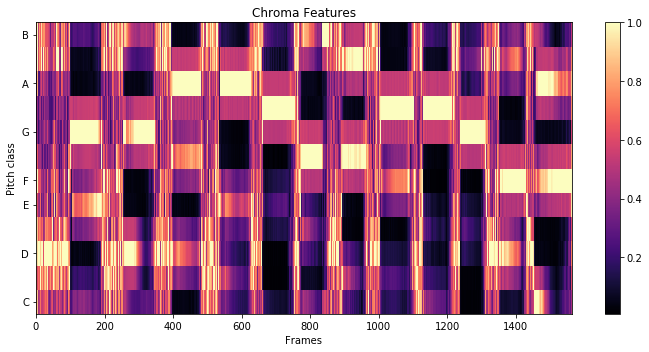

In [28]:
cf = chroma_features(file=FILE_PATH, 
                     sample_rate=SAMPLE_RATE, 
                     offset=OFFSET, 
                     duration=DURATION, 
                     hop_length=HOP_LENGTH, 
                     display=VISUALIZATION)

#### Analysing the extracted features

100%|██████████| 1563/1563 [00:01<00:00, 1000.45it/s]


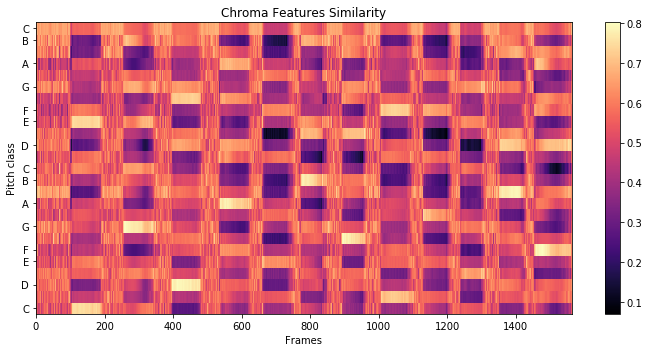

In [29]:
fa = feature_analysis(cf, 
                      sample_rate=SAMPLE_RATE, 
                      display=VISUALIZATION)

#### Applying the Hanning window for noise reduction

100%|██████████| 25/25 [00:07<00:00,  3.25it/s]


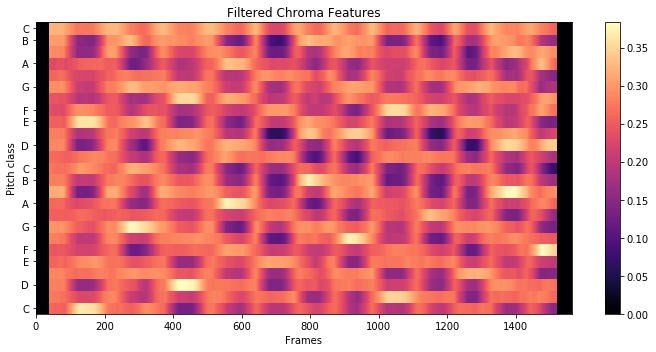

In [30]:
sf = smoothing_window(fa, 
                      sample_rate=SAMPLE_RATE, 
                      kernel_size=KERNEL_SIZE, 
                      kernel_type='window', 
                      display=VISUALIZATION)

print(' '.join(map(str, sf)), 
      file=open("output/log/{s}_window_{sr}_{h}.txt".format(s=SAMPLE_NAME, 
                                                            sr=SAMPLE_RATE, 
                                                            h=HOP_LENGTH), "a"))

#### Map the chroma feature vectors to equivalent chord

In [36]:
notation = features_to_chords(sf)
string = save_notation(notation)
print(string)

 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - C C C C C C C
 C C C C C C C C C C Em Em
 C C C C C C C C C C C C
 C C C C C C C C C C C C
 C C C C C C C C C C C C
 C C C C Em Em Em Em Em Em Em Em
 Em Em Em Em Em Em Em Em Em Em Em Em
 Em Em Em Em Em Em Em Em Em Em Em Em
 Em C C C C - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - - G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G G G G G
 G G G G G G G G - - - -
 - - - - - - - - - - - -
 - - - - - - - - - - - -
 - - - - - - D D D D D D
 D D D D D D D D D D D D
 D D D D D D D D D D D D
 D D D D D D D D D D D D
 D D D D D D D D D D D D
 D D D D D D D D D D D D
 D D D D D D D 